In [1]:
from methods_model_development import *

This notebook contains:
1. Class imbalance inspection
2. Dimensionality reduction
3. Cluster analysis

In [2]:
label_encoder = LabelEncoder()

In [3]:
embeddings = pd.read_parquet('datasets/embeddings/embedded_politicians_traintest.parquet')
print(f'The dataset containing unique embeddings\nof both politicians and unknowns\nis of shape {embeddings.shape}\nand contains the columns:\n{embeddings.columns.tolist()}')

The dataset containing unique embeddings
of both politicians and unknowns
is of shape (4287, 4)
and contains the columns:
['embedding', 'dataset', 'image_filename', 'image_path']


In [4]:
y = embeddings['dataset']

## 1. Class imbalance inspection

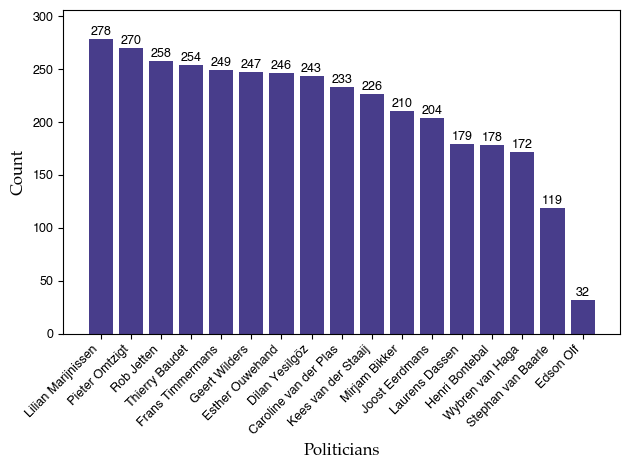

In [11]:
counter = Counter(y)
politicians = list(counter.keys())
counts = list(counter.values())

if 'Unknown' in politicians:
    unknown_index = politicians.index('Unknown')
    politicians.pop(unknown_index)
    counts.pop(unknown_index)

# Sort
sorted_indices = sorted(range(len(counts)), key=lambda k: counts[k], reverse=True)
politicians = [politicians[i] for i in sorted_indices]
counts = [counts[i] for i in sorted_indices]

# Colors
colors = ['darkslateblue']

# Plot
plt.bar(politicians, counts, color=colors)

# Add labels and title
plt.xlabel('Politicians', fontdict=axis_font)
plt.ylabel('Count', fontdict=axis_font)
#plt.title('Data Imbalance', fontdict=title_font)

# Set the x-ticks and y-ticks
plt.xticks(rotation=45, ha='right', fontsize=xticks_font['size'], family=xticks_font['family'], 
           weight=xticks_font['weight'], color='black')
plt.yticks(fontsize=yticks_font['size'], family=yticks_font['family'], 
           weight=yticks_font['weight'], color='black')

# Adjust the y-axis limit
max_count = max(counts)
plt.ylim(0, max_count + (0.1 * max_count))

# Display counts
for i, count in enumerate(counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', 
             fontsize=yticks_font['size'], family=yticks_font['family'], 
             weight=yticks_font['weight'], color='black')

plt.tight_layout()
plt.savefig('../z__visual-outputs-matplotlib/training_data_imbalance.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 2. Cluster analysis
Note: embeddings with class label 'Unknown' are not part of the cluster analysis

In [23]:
embeddings_pol = embeddings[embeddings['dataset'] != 'Unknown']
print(f'The dataset containing unique embeddings\nof only politicians\nis of shape {embeddings_pol.shape}\nand contains the columns:\n{embeddings_pol.columns.tolist()}')

The dataset containing unique embeddings
of only politicians
is of shape (3598, 4)
and contains the columns:
['embedding', 'dataset', 'image_filename', 'image_path']


This part of the code makes use of global variables:
- embeddings_array ; the array that features all the embeddings for the data in the right format
- labels_pol ; the labels belonging to the embeddings, i.e. embeddings_pol['dataset']
- unique_labels ; the set of unique labels for the embedded politicians in the dataset, i.e. set(labels_pol)
- cmap ; the colormap facilitating visual comparison
- norm ; variable necessary for creating the color map 

In [24]:
embedding_lengths = embeddings_pol['embedding'].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else None)
if embedding_lengths.isnull().any():
    raise ValueError("Found non-list or non-array elements in embeddings.")
if embedding_lengths.nunique() != 1:
    raise ValueError("Not all embeddings have the same length.")

try:
    embeddings_array = np.vstack(embeddings_pol['embedding'].apply(lambda x: np.array(x)).values)
except ValueError as e:
    raise ValueError("Failed to convert embeddings to a consistent 2D NumPy array.") from e

print(f"The embeddings array is of shape: {embeddings_array.shape},\ni.e. it has {embeddings_array.shape[0]} stored embeddings\nthat each have a length/dimensionality of {embeddings_array.shape[1]}")

The embeddings array is of shape: (3598, 512),
i.e. it has 3598 stored embeddings
that each have a length/dimensionality of 512


In [25]:
labels_pol = embeddings_pol['dataset']
unique_labels = set(labels_pol)
cmap = plt.get_cmap('tab20', len(unique_labels))
norm = Normalize(vmin=0, vmax=len(unique_labels)-1)

### a: TSNE in 2 dimensions
##### t-distributed Stochastic Neighbor Embedding
"t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results", explained on scikit-learn documentation (scikit-learn https://scikit-learn.org/0.16/modules/generated/sklearn.manifold.TSNE.html). For more info, note the detailed description on WikiPedia (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) or watch the comprehensive video by StatQuest (https://www.youtube.com/watch?v=NEaUSP4YerM)

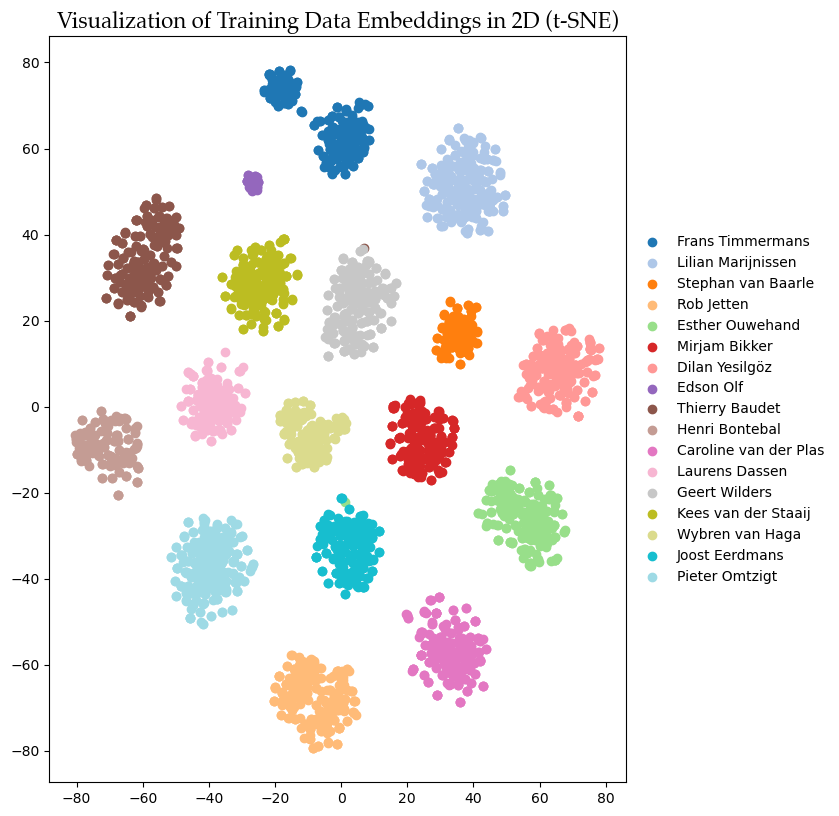

In [27]:
# TSNE
tsne = TSNE(n_components=2, random_state=7)

# Fit and transform the embeddings
tsne_data = tsne.fit_transform(embeddings_array)

# Scatter plot visualization
plt.figure(figsize=(10, 8))
for i, label in enumerate(unique_labels):
    indices = [j for j, l in enumerate(labels_pol) if l == label]
    plt.scatter(
        tsne_data[indices, 0],
        tsne_data[indices, 1],
        label=label,
        color=cmap(norm(i)),
    )

plt.legend(
    loc='center left', 
    bbox_to_anchor=(1, 0.5), 
    fontsize=10, 
    frameon=False)


plt.tight_layout(rect=[0, 0, 0.85, 1])  
plt.title('Visualization of Training Data Embeddings in 2D (t-SNE)', fontdict=title_font)
plt.savefig('../z__output/training_data_2Dclusters_tsne.pdf', format='pdf', bbox_inches='tight')
plt.show()

### b. PCA with 64 components visualized in two dimensions
##### Principal component analysis (PCA).
"Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD. It uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of Halko et al. 2009, depending on the shape of the input data and the number of components to extract.", documented on scikit-learn's documentation. For more info, note the detailed description on WikiPedia (https://en.wikipedia.org/wiki/Principal_component_analysis) or watch one of the many explainers on YouTube (I recommend StatQuest, https://www.youtube.com/watch?v=FgakZw6K1QQ)

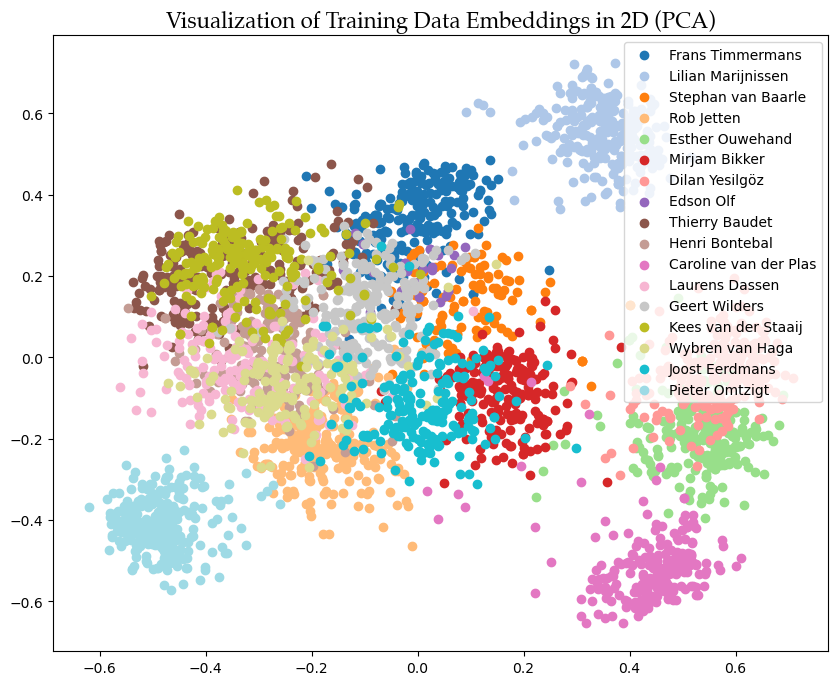

In [28]:
# Create a PCA model
pca = PCA(n_components=64)

# Fit and transform the data
pca_data = pca.fit_transform(embeddings_array)

# Create a scatter plot with a unique color for each label
plt.figure(figsize=(10, 8))
for i, label in enumerate(unique_labels):
    indices = [j for j, l in enumerate(labels_pol) if l == label]
    plt.scatter(
        pca_data[indices, 0],
        pca_data[indices, 1],
        label=label,
        color=cmap(norm(i)),
    )

plt.legend(
    loc='center left', 
    bbox_to_anchor=(1, 0.5), 
    fontsize=10, 
    frameon=False)

plt.title('Visualization of Training Data Embeddings in 2D (PCA)', fontdict=title_font)
plt.savefig('../z__output/training_data_2Dclusters_PCA.pdf', format='pdf', bbox_inches='tight')
plt.legend()
plt.show()

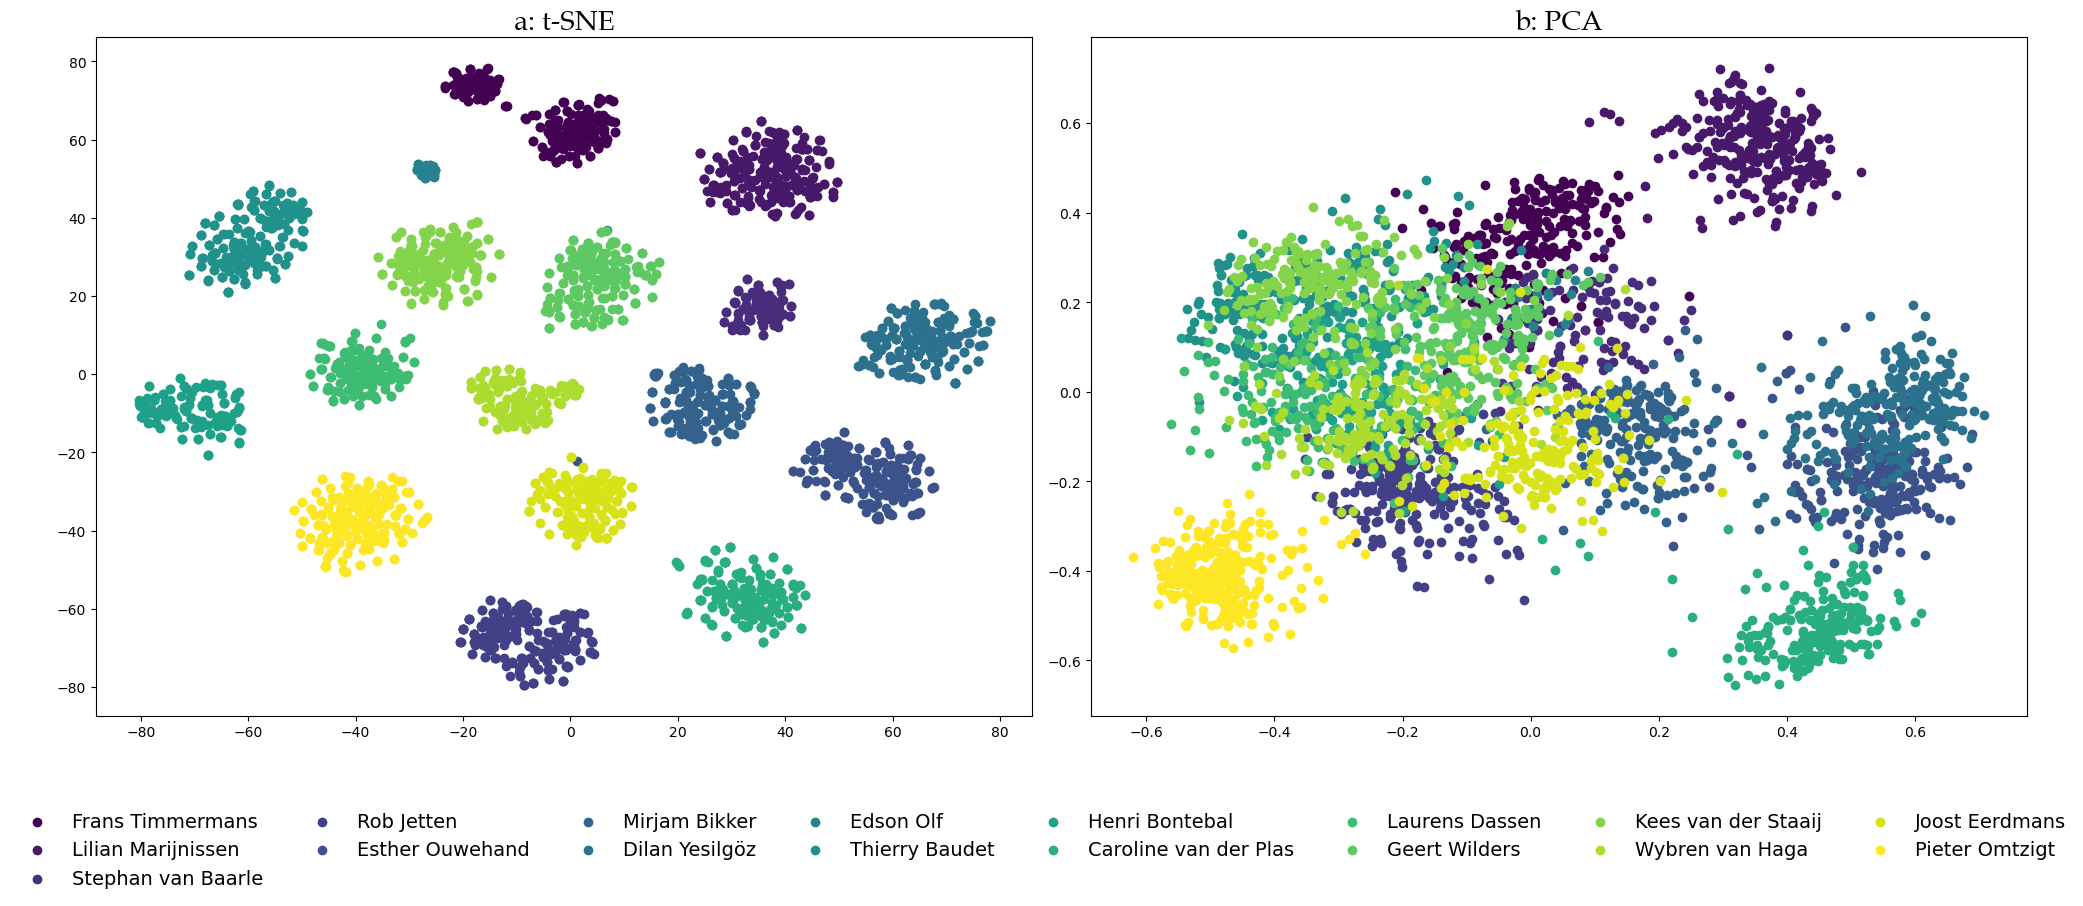

In [41]:
# Create the color map and normalization
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=len(unique_labels) - 1)

# TSNE
tsne = TSNE(n_components=2, random_state=7)
tsne_data = tsne.fit_transform(embeddings_array)

# PCA
pca = PCA(n_components=2)  # Change to 2 components for 2D visualization
pca_data = pca.fit_transform(embeddings_array)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot t-SNE
for i, label in enumerate(unique_labels):
    indices = [j for j, l in enumerate(labels_pol) if l == label]
    ax1.scatter(
        tsne_data[indices, 0],
        tsne_data[indices, 1],
        label=label,
        color=cmap(norm(i)),
    )
ax1.set_title('a: t-SNE', fontfamily='Palatino', fontsize=20)

# Plot PCA
for i, label in enumerate(unique_labels):
    indices = [j for j, l in enumerate(labels_pol) if l == label]
    ax2.scatter(
        pca_data[indices, 0],
        pca_data[indices, 1],
        label=label,
        color=cmap(norm(i)),
    )
ax2.set_title('b: PCA', fontfamily='Palatino', fontsize=20)

# Single Legend centered below the plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), fontsize=14, frameon=False, ncol=len(unique_labels)//2)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the combined figure
plt.savefig('../z__output/combined_tsne_pca_visualization.pdf', format='pdf', bbox_inches='tight')

# Show plot
plt.show()

### c. Comparison
#### i. Find optimal n_components for PCA
First, it is important to understand what number of components using PCA gives the most accurate result. This analysis is visualized with a hoverable plot.

In [12]:
# Scale on which to explore PCA accuracy (<512, i.e. the current dimensionality of the embeddings
pca_components_list = [2, 4, 8, 16, 32, 64, 128, 256]
pca_accuracy_scores = []

for n_components in pca_components_list:
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(embeddings_array)
    
    # Split the data into training and testing sets
    X_train_pca, X_test_pca, y_train, y_test = train_test_split(
        pca_data, labels_pol, test_size=0.3, random_state=7
    )
    
    # Train logistic regression to compare accuracies for the different numbers of components
    clf_pca = LogisticRegression(max_iter=10000)
    clf_pca.fit(X_train_pca, y_train)
    pca_pred = clf_pca.predict(X_test_pca)
    
    # Get accuracy score and append it to the list
    accuracy_pca = accuracy_score(y_test, pca_pred)
    pca_accuracy_scores.append(round(accuracy_pca, 3))

    # Print the scores at the dimensionality level
    print(f'With {n_components}, PCA performs at an accuracy of: {round(accuracy_pca, 5)}')

# Plotly
trace = go.Scatter(
    x=pca_components_list,
    y=pca_accuracy_scores,
    mode='lines+markers',
    marker=dict(color='yellowgreen'),
    text=[f'PCA Accuracy: {acc:.3f}' for acc in pca_accuracy_scores],
    hoverinfo='text+x+y',
)
layout = go.Layout(
    title='Accuracy of Logistic Regression with PCA, applied to FaceNet embeddings with 512 original dimensions',
    xaxis=dict(title='Number of PCA Components'),
    yaxis=dict(title='Accuracy'),
    hovermode='closest'
)

fig = go.Figure(data=[trace], layout=layout)

# Display plot
plot(fig, filename='pca_accuracy_plot_for_facenet_embeddings.html', auto_open=True)

With 2, PCA performs at an accuracy of: 0.68056
With 4, PCA performs at an accuracy of: 0.925
With 8, PCA performs at an accuracy of: 0.98056
With 16, PCA performs at an accuracy of: 0.99537
With 32, PCA performs at an accuracy of: 0.99722
With 64, PCA performs at an accuracy of: 0.99907
With 128, PCA performs at an accuracy of: 0.99907
With 256, PCA performs at an accuracy of: 0.99907


'pca_accuracy_plot_for_facenet_embeddings.html'

The analysis shows that 64 principal components are able to capture most of the variance in the data. Let's take a closer look at the distribution of explained variance with a ScreePlot

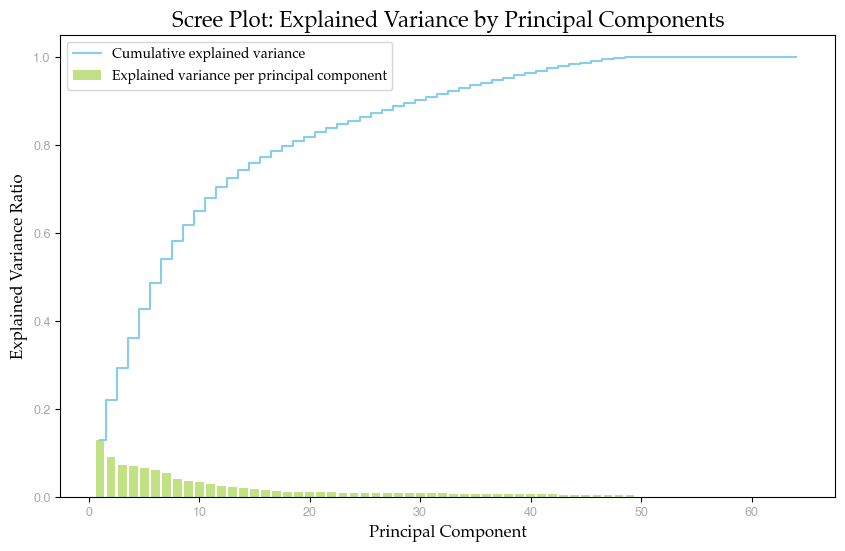

In [13]:
# Fit PCA with 64 components
pca = PCA(n_components=64)
pca.fit(embeddings_array)

# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance 
cumulative_variance = np.cumsum(explained_variance)

# Plotting the scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, 65), explained_variance, alpha=0.6, label='Explained variance per principal component', color='yellowgreen')
plt.step(range(1, 65), cumulative_variance, where='mid', label='Cumulative explained variance', color='skyblue')

# Layout
plt.xlabel('Principal Component', fontdict=axis_font)
plt.ylabel('Explained Variance Ratio', fontdict=axis_font)
plt.title('Scree Plot: Explained Variance by Principal Components', fontdict=title_font)
plt.xticks(fontsize=xticks_font['size'], fontweight=xticks_font['weight'], color=xticks_font['color'], family=xticks_font['family'])
plt.yticks(fontsize=yticks_font['size'], fontweight=yticks_font['weight'], color=yticks_font['color'], family=yticks_font['family'])

# Legend
plt.legend(prop={'family': legend_font['family'], 'size': legend_font['size'], 'weight': legend_font['weight']})

plt.show()

#### ii. Compare accuracy scores for t-SNE and the optimal n_components found for PCA 

In [14]:
# Split train/test
X_train_pca, X_test_pca, y_train, y_test = train_test_split(pca_data, labels_pol, test_size=0.3, random_state=7)
X_train_tsne, X_test_tsne, _, _ = train_test_split(tsne_data, labels_pol, test_size=0.3, random_state=7)

# Logistic regression
clf_pca = LogisticRegression(max_iter=10000)
clf_pca.fit(X_train_pca, y_train)
pca_pred = clf_pca.predict(X_test_pca)

clf_tsne = LogisticRegression(max_iter=10000)
clf_tsne.fit(X_train_tsne, y_train)
tsne_pred = clf_tsne.predict(X_test_tsne)

# Compare accuracy
accuracy_pca = accuracy_score(y_test, pca_pred)
accuracy_tsne = accuracy_score(y_test, tsne_pred)

print(f'PCA Accuracy: {accuracy_pca}')
print(f't-SNE Accuracy: {accuracy_tsne}')

PCA Accuracy: 0.9990740740740741
t-SNE Accuracy: 0.9990740740740741


#### Write new embedding dataset with PCA and t-SNE vectors (both having a lower number of dimensionality)
This data is used in the next script (02_model_development.ipynb) to arrive at a classification model

In [15]:
embedding_lengths_full = embeddings['embedding'].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else None)
if embedding_lengths_full.isnull().any():
    raise ValueError("Found non-list or non-array elements in embeddings.")
if embedding_lengths_full.nunique() != 1:
    raise ValueError("Not all embeddings have the same length.")

try:
    embeddings_array_full = np.vstack(embeddings['embedding'].apply(lambda x: np.array(x)).values)
except ValueError as e:
    raise ValueError("Failed to convert embeddings to a consistent 2D NumPy array.") from e

print(f"The embeddings array including\nboth politicians and unknowns is of shape: {embeddings_array_full.shape},\ni.e. it has {embeddings_array_full.shape[0]} stored embeddings\nthat each have a length/dimensionality of {embeddings_array_full.shape[1]}")

The embeddings array including
both politicians and unknowns is of shape: (4287, 512),
i.e. it has 4287 stored embeddings
that each have a length/dimensionality of 512


In [16]:
pca = PCA(n_components=64)
pca_data_full = pca.fit_transform(embeddings_array_full)
print(f'The embeddings with PCA applied are of shape {pca_data_full.shape}')

tsne = TSNE(n_components=2, random_state=7)
tsne_data_full = tsne.fit_transform(embeddings_array_full)
print(f'The embeddings with t-SNE applied are of shape {tsne_data_full.shape}')

The embeddings with PCA applied are of shape (4287, 64)
The embeddings with t-SNE applied are of shape (4287, 2)


## Write to file to preserve new embeddings and continue to the next script for model development

In [17]:
embeddings['PCA_64D'] = pca_data_full.tolist()
embeddings['tSNE_2D'] = tsne_data_full.tolist()

In [18]:
# Inspect
embeddings.head()

,embedding,dataset,image_filename,image_path,PCA_64D,tSNE_2D
0,"[0.067710534, -0.0724106, 0.033920772, -0.0381...",Wybren van Haga,Wybren van Haga_4221.jpg,datasets/images/isolated_train_faces_scraped_m...,"[-0.4723623991012573, -0.07542860507965088, 0....","[-5.361752510070801, 5.15596866607666]"
1,"[0.12828477, -0.06648803, 0.0035601046, -0.017...",Wybren van Haga,Wybren van Haga_4235.jpg,datasets/images/isolated_train_faces_scraped_m...,"[-0.2644948959350586, -0.16357682645320892, 0....","[-4.690042495727539, -4.3525309562683105]"
2,"[0.07021605, -0.08837313, -0.0012089352, -0.03...",Wybren van Haga,Wybren van Haga_6608.jpg,datasets/images/isolated_train_faces_scraped_m...,"[-0.29261747002601624, -0.12338461726903915, 0...","[-0.5903055667877197, 3.823801040649414]"
3,"[0.08472057, -0.018700434, -0.0035296865, -0.0...",Wybren van Haga,Wybren van Haga_1991.jpg,datasets/images/isolated_train_faces_scraped_m...,"[-0.3367215096950531, -0.25563740730285645, 0....","[-1.7174537181854248, -2.862802267074585]"
4,"[0.07126795, -0.11454334, -0.003278402, -0.019...",Wybren van Haga,Wybren van Haga_1985.jpg,datasets/images/isolated_train_faces_scraped_m...,"[-0.3624779284000397, -0.14456318318843842, 0....","[-3.0287673473358154, 5.996276378631592]"


In [19]:
# Write to file 
embeddings.to_parquet('datasets/embeddings/embedded_politicians_pca_tsne.parquet')